In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt

import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

### Import data

In [2]:
cc_info = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/10.credit_card/cc_info.csv')
cc_info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [3]:
cc_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   credit_card        984 non-null    int64 
 1   city               984 non-null    object
 2   state              984 non-null    object
 3   zipcode            984 non-null    int64 
 4   credit_card_limit  984 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 38.6+ KB


In [4]:
transactions = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/10.credit_card/transactions.csv', parse_dates=['date'])
transactions.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   credit_card                294588 non-null  int64         
 1   date                       294588 non-null  datetime64[ns]
 2   transaction_dollar_amount  294588 non-null  float64       
 3   Long                       294588 non-null  float64       
 4   Lat                        294588 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 11.2 MB


### Data Processing

In [6]:
data = pd.merge(left=transactions, right=cc_info, on='credit_card', how='left')
data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [7]:
# extract month, weekday, and hour information
data['month'] = data['date'].apply(lambda x: x.month)
data['day'] = data['date'].apply(lambda x: x.day)
data['weekday'] = data['date'].apply(lambda x: x.dayofweek)
data['hour'] = data['date'].apply(lambda x: x.hour)

# drop useless features
data = data.drop(labels='date', axis=1)

data.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20


### Q1: Your boss wants to identify those users that in your dataset never went above the monthly credit card limit(calendar month). The goal of this is to automatically increase their limit. Can you send him the list of Ids?

In [8]:
def monthly_transaction(df):
    """ function to calculate montly total transactions """
    total_trans = df['transaction_dollar_amount'].sum()
    credit_limit = df['credit_card_limit'].values[0]
    
    return pd.Series([total_trans, credit_limit], index=['total_transaction', 'credit_limit'])

In [9]:
# find users who never exceed credit limit
grouped = data.groupby(['credit_card', 'month']).apply(monthly_transaction)
grouped = grouped.reset_index()

grouped

,credit_card,month,total_transaction,credit_limit
0,1003715054175576,7,162.56,20000.0
1,1003715054175576,8,8441.51,20000.0
2,1003715054175576,9,11281.56,20000.0
3,1003715054175576,10,8954.21,20000.0
4,1013870087888817,7,281.43,15000.0
...,...,...,...,...
3792,9986135779184360,10,11796.95,14000.0
3793,9999757432802760,7,77.59,6000.0
3794,9999757432802760,8,4408.83,6000.0
3795,9999757432802760,9,6814.72,6000.0


In [10]:
grouped['exceed'] = (grouped['total_transaction'] > grouped['credit_limit']).astype(int)
grouped_sum = grouped.groupby('credit_card')['exceed'].sum().reset_index()

lists = grouped_sum[grouped_sum['exceed'] == 0][['credit_card']]

print('Valid credit cards:\t', len(lists))
lists.head()

Valid credit cards:	 862


,credit_card
0,1003715054175576
1,1013870087888817
2,1023820165155391
3,1073931538936472
4,1077622576192810


There are 862 credit cards in total that never exceed their credit limit.

### Q2: On the other hand, she wants you to implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that. We assume here that at the beginning of the new month, user total money spent gets reset to zero (i.e. she pays the card fully at the end of each month) Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

In [11]:
def alert(data, month, day):
    """ function to return the list of credit cards that exceed the limit """
    data = data[(data['month'] == month) & (data['day'] <= day)]
    limit = data.groupby('credit_card')['credit_card_limit'].min().reset_index()
    transaction = data.groupby('credit_card')['transaction_dollar_amount'].sum().reset_index()
    
    merged = pd.merge(left=transaction, right=limit, on='credit_card', how='left')
    result = merged[merged['transaction_dollar_amount'] > merged['credit_card_limit']]
    
    return result

In [12]:
# example
alert(data, month=8, day=20)

,credit_card,transaction_dollar_amount,credit_card_limit
194,2850146878241916,4012.81,4000
319,3936887050542904,5352.07,4000
341,4118286032166087,3416.52,3000
383,4462290711836916,3119.53,2000
525,5723635641134781,2161.30,2000
698,7299183791723634,7074.49,7000
772,7850942767136368,5704.00,4000
834,8522875529951473,5860.89,5000
874,8972201384562696,5266.08,5000


### Q3: Finally, your boss is very concerned about frauds cause they are a huge cost for credit card companies. She wants you to implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further.

There are two factors which impact a transaction is fraud or not:

- if the transaction violates that user's consumption habit. For example, if a user spend less then 200 each transaction most of the time, then a transaction more than 1000 will be highly suspicious.
- if user spend the money far from his home, although it is possible due to traveling, but it's still very suspicious.

Although the data provide each transaction's geometric information and card holder's home, unfortunately, due to time limits, I cannot relate each transation's 'Long' and 'Lat' with that card holder's home address. so I have to drop the second factor listed above, and only make features from user's previous comsumption history.

If given more time, I would use some Map Web API to map Long/Lat to address, and compare with card-holder's address, which will be a very useful feature to detect credit fraud.

In [13]:
data.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20


In [14]:
def statistics_by_card(s):
    ps = [25, 50, 75]
    d = np.percentile(s,ps)
    return pd.Series(d,index=['{}%'.format(p) for p in ps])

tran_statistics = data.groupby('credit_card')['transaction_dollar_amount'].apply(statistics_by_card).unstack()

tran_statistics.head()

,25%,50%,75%
credit_card,,,
1003715054175576,59.01,93.73,124.63
1013870087888817,58.09,87.67,128.02
1023820165155391,55.43,85.78,122.83
1073931538936472,108.08,147.19,194.83
1077622576192810,122.93,148.18,160.11


In [15]:
# merge 'transaction' with 'previous consumption statistics'
X = pd.merge(data,tran_statistics,how='left',left_on='credit_card',right_index=True)

X.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,25%,50%,75%
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0,59.01,93.73,124.63
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22,59.01,93.73,124.63
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18,59.01,93.73,124.63
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19,59.01,93.73,124.63
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20,59.01,93.73,124.63


In [16]:
data = X

We only care about current amount and previous consumption history, so we can just keep those useful features.

In [17]:
X = X.loc[:,['transaction_dollar_amount','25%','50%','75%','credit_card_limit']]

X.head()

,transaction_dollar_amount,25%,50%,75%,credit_card_limit
0,43.78,59.01,93.73,124.63,20000
1,103.15,59.01,93.73,124.63,20000
2,48.55,59.01,93.73,124.63,20000
3,136.18,59.01,93.73,124.63,20000
4,71.82,59.01,93.73,124.63,20000


In [18]:
X.describe()

,transaction_dollar_amount,25%,50%,75%,credit_card_limit
count,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000
mean,86.008036,43.265113,69.081697,97.282645,15502.053716
std,124.655954,21.471896,35.160028,49.919646,7956.291556
min,0.010000,6.150000,7.320000,9.120000,2000.000000
25%,29.970000,27.960000,43.590000,60.812500,10000.000000
50%,58.470000,40.595000,65.190000,91.832500,15000.000000
75%,100.400000,56.215000,89.710000,127.345000,20000.000000
max,999.970000,137.690000,222.290000,318.730000,55000.000000


Then we can reduce data to 2D, and visualize it to get some hint. However, since credit_card_limit has much higher variance, we need to scale each feature to unit variance before applying PCA, otherwise, the principle components will be highly aligned with 'credit_card_limit' which doesn't provide useful information.

In [19]:
X = scale(X)

Use PCA to reduce feature matrix to 2D

In [20]:
pca = PCA(n_components=2)
X2d = pca.fit_transform(X)
X2d = pd.DataFrame(X2d,columns=['pc1','pc2'])

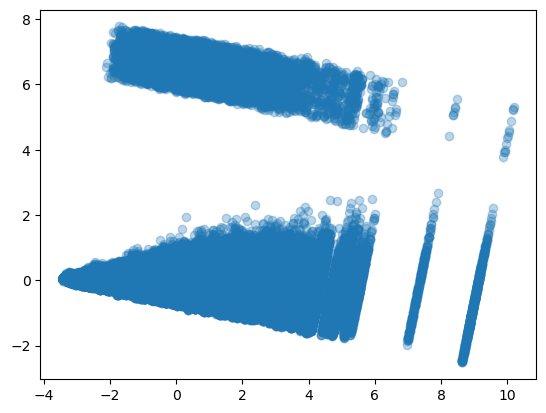

In [21]:
plt.scatter(X2d.pc1,X2d.pc2,alpha=0.3)

### Kmeans to cluster
Above plot shows a good sign, that is, the data is well seperated. Also, from the above plot, we may say that the data can be grouped into 6 clusters.

Then, we use Kmeans algorithm to perform the clustering.

In [22]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)

KMeans(n_clusters=6)

In [23]:
X2d['label'] = kmeans.labels_
print(X2d.label.value_counts())

5    107816
2     73594
4     49048
1     32958
0     25736
3      5436
Name: label, dtype: int64


From the above result, cluster 4 has apparently fewer transcations compared with others. This makes senses, because fraud activity, isn't that normal.

Then we plot the clusters in 2D, to check their distribution.

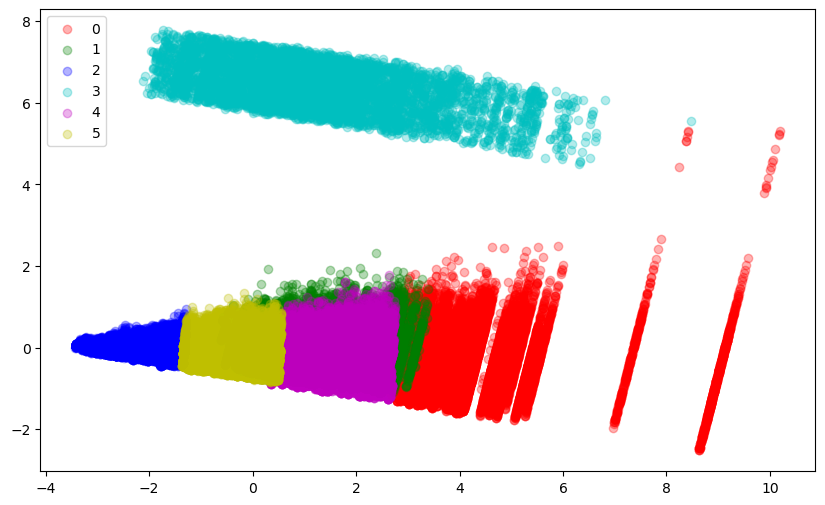

In [24]:
colors = itertools.cycle( ['r','g','b','c','m','y','k'] )

plt.rc('figure',figsize=(10,6))
for label in range(n_clusters) :
    temp = X2d.loc[X2d.label == label,:]
    plt.scatter(temp.pc1,temp.pc2,c=next(colors),label=label,alpha=0.3)

plt.legend(loc='best')

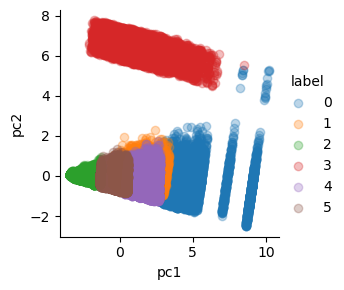

In [25]:
g = sns.FacetGrid(X2d, hue="label")
g.map(plt.scatter, "pc1", "pc2", alpha=0.3)
g.add_legend()

### Check the result

In [26]:
pd.DataFrame(X2d.label.value_counts())

,label
5,107816
2,73594
4,49048
1,32958
0,25736
3,5436


In [27]:
suspicious_label = pd.DataFrame(X2d.label.value_counts()).idxmin()[0]
suspicious_label

3

In [28]:
data.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,25%,50%,75%
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0,59.01,93.73,124.63
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22,59.01,93.73,124.63
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18,59.01,93.73,124.63
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19,59.01,93.73,124.63
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20,59.01,93.73,124.63


In [29]:
suspect = data.loc[X2d.label==suspicious_label,['credit_card','transaction_dollar_amount','25%','50%','75%','credit_card_limit']]

suspect.sample(10)

,credit_card,transaction_dollar_amount,25%,50%,75%,credit_card_limit
255833,8569454397966652,816.62,42.8350,69.980,98.9875,16000
293329,9946917923319410,961.04,43.6100,76.230,102.6400,15000
21343,1582804611799136,978.35,86.3600,138.870,187.9575,36000
115682,4386321242706043,864.42,62.6100,97.925,140.5500,20000
247743,8353267890887335,881.75,19.2350,29.590,40.3275,10000
209350,7246108290515977,886.06,45.5850,69.580,101.3750,16000
1020,1023820165155391,807.32,55.4300,85.780,122.8300,28000
122051,4672118413151569,830.21,49.8400,85.395,123.9500,14000
15144,1402909379316770,874.86,9.8275,13.985,18.8050,10000
222135,7685625385316960,806.95,27.1450,43.505,63.4550,14000


From the randomly sampled suspicious transactions list above, we can find each transaction amount is much higher than that user's 75th percentile in his/her previous consumption history.

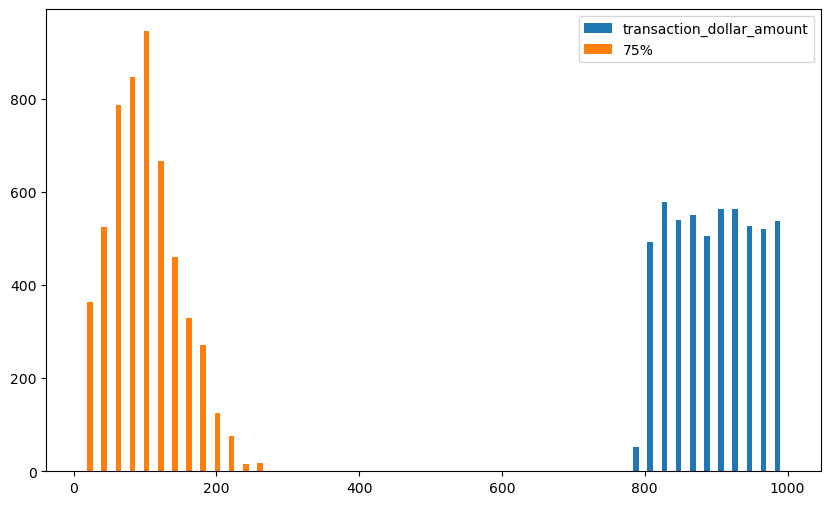

In [30]:
labels = ['transaction_dollar_amount','75%']
plt.hist(suspect.loc[:,labels].values,bins=50,label=labels)
plt.legend(loc='best')

From the histogram above, we can know that those transaction amount is much higher than '75th percentile', which is very suspicious and worth further investigation.